In [1]:
from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP
from helper import DynamicBundleStabilisation, solve_RMLP_with_bundle, better_pricing_problem_solver

In [2]:
import importlib
import models
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP
from helper import DynamicBundleStabilisation, solve_RMLP_with_bundle, better_pricing_problem_solver

In [23]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=False, rakes = 5)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 936 nodes and 34352 edges


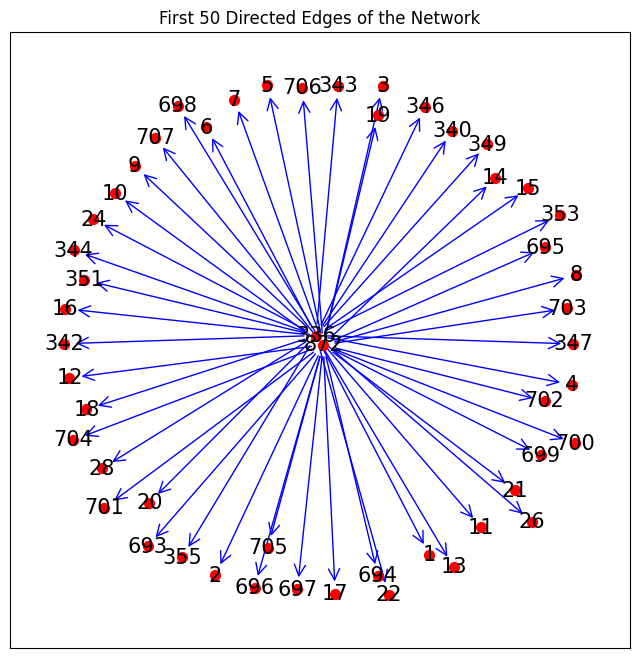

In [24]:
draw_graph_with_edges(graph)

In [25]:
def change_in_duals(curr_duals, prev_duals):
    count = 0
    for i, dual in enumerate(curr_duals):
        if abs(curr_duals[dual] - prev_duals[dual]) < 1e-3:
            count += 1
    print(f"Number of duals that are same is {count}")

In [ ]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 5, show_logs = False, show_duties = False, show_roster_stats = False)
# init_duties, duty_count = simple_mpc(graph, service_dict, show_logs=False)
print(f"Initial number of duties: {len(init_duties)}")
cutoff_obj = len(init_duties)
print("For MPC method:", "\n")
all_covered = count_overlaps(init_duties, services)
print("\n")
init_duties2 = init_duties.copy()


bundle_stabiliser = DynamicBundleStabilisation(services, max_bundle_size = 5, alpha = 0.7)
prev_duals = {f"Service_{service.serv_num}": 0 for service in services}

for _ in range(500):
    # selected_duties, duals, selected_duty_vars, obj = solve_RMLP_with_bundle(services=services, duties=init_duties2, bundle_stabiliser=bundle_stabiliser)
    selected_duties, duals, selected_duty_vars, obj = solve_RMLP(services=services, duties=init_duties2)
    change_in_duals(duals, prev_duals)
    prev_duals = duals
    # path, length, graph_cp = better_pricing_problem_solver(graph, duals = duals, prev_paths=init_duties2, epsilon = 1e-3)
    path, length, graph_cp = new_duty_with_bellman_ford(graph, dual_values=duals)
    print(_, obj, length)
    if path is None:
        print(f"iteration number {_} breaks......")
        break
    init_duties2.append(path[1:-1])

print("IP starts solving.......")
obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*60)
tt = []
for duty_num in selected_duties:
    tt.append(init_duties2[duty_num])
count_overlaps(tt, services)

Initial number of duties: 902
For MPC method: 

Number of duties selected: 902
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


Number of duals that are same is 32
0 902.0 -57.0
Number of duals that are same is 876
1 848.0 -56.0
Number of duals that are same is 878
2 794.0 -50.0
Number of duals that are same is 883
3 747.0 -28.0
Number of duals that are same is 904
4 723.0 -28.0
Number of duals that are same is 906
5 697.0 -27.0
Number of duals that are same is 906
6 673.0 -27.0
Number of duals that are same is 906
7 649.0 -27.0
Number of duals that are same is 906
8 625.0 -27.0
Number of duals that are same is 904
9 603.0 -27.0
Number of duals that are same is 905
10 578.0 -26.0
Number of duals that are same is 903
11 555.0 -26.0
Number of duals that are same is 905
12 532.0 -25.0
Number of duals that are same is 907
13 509.0 -25.0
Number of duals that are same is 904
14 489.0 -24.0
Number of duals that are same is 

In [27]:
obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.001, timelimit=60*60)
tt = []
for duty_num in selected_duties:
    tt.append(init_duties2[duty_num])
count_overlaps(tt, services)

Number of duties selected: 902
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


True

In [ ]:
for duty in init_duties:
    if duty not in tt:
        print(duty)

In [ ]:
xd = init_duties.copy()

In [ ]:
for duty in xd:
    if duty not in init_duties:
        print(duty)

In [ ]:
# To check number of services that overlap in all selected duties
# Run after column generation

for i in range(1, 21, 2):
    tt = 0.01 * i
    init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 20, show_logs = False, show_duties = False, show_roster_stats = False)
    print(f"Initial number of duties: {len(init_duties)}", "\n", "For MPC method:", "\n")
    all_covered = count_overlaps(init_duties, services)
    print("\n")
    init_duties2 = init_duties.copy()
    objectives, selected_duties, indexes = column_generation(method=1, graph = graph, services = services, init_duties= init_duties2, num_iter = 400, threshold=tt) 
    print(f"Threshold: {tt}")
    all_covered = count_overlaps(selected_duties, services)
    print("\n")
    if not all_covered:
        print("<---------------------Not all services covered in the previous iteration--------------------->")
        break

Initial number of duties: 160 
 For MPC method: 

Number of duties selected: 160
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934




<h3>For number of rakes = 3</h3>
Threshold: 0.17<br>
Number of duties selected: 18<br>
Total number of services: 64<br>
Number of services that overlap in duties: 55<br>
Number of services covered in duties: 64<br>

<h3>For number of rakes = 4 </h3>
Threshold: 0.15<br>
Number of duties selected: 29<br>
Total number of services: 86<br>
Number of services that overlap in duties: 64<br>
Number of services covered in duties: 86<br>

<h3>For number of rakes = 5 </h3>
Threshold: 0.18<br>
Number of duties selected: 33<br>
Total number of services: 106<br>
Number of services that overlap in duties: 84<br>
Number of services covered in duties: 106<br>

In [ ]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 10, show_logs = False, show_duties = False, show_roster_stats = False)
print(init_duties)

[[336, 343, 30, 741, 128], [872, 698, 69, 398, 426, 459, 475, 490, 507], [873, 349, 50, 757, 158, 438], [527], [880, 56, 95, 772, 206, 241], [693, 7, 34, 73, 111], [1, 718, 89, 125, 790, 805, 834], [929, 14, 63, 765, 194, 229, 842], [5, 359, 382, 107, 777, 210, 247], [702, 726, 763, 168, 462, 263, 299], [18, 734, 140, 433, 453, 470, 496, 511], [351, 366, 388, 405, 161, 796, 225, 499], [23, 390, 418, 192, 831, 847, 867], [724, 102, 424, 202, 278, 905], [135, 798, 810, 266, 903], [144, 177, 825, 284, 316], [173, 236, 273, 307], [914], [917], [684]]


In [ ]:
# block to write selected duties to csv file

output_filename = "duties_after_gen/duties_after_gen_701_all.csv"

with open(output_filename, mode="w", newline="") as file:
    # Define column headers
    fieldnames = [
        "Service Number", "Train Number", "Start Station", "Start Time (mins)", 
        "End Station", "End Time (mins)", "Direction", "Service Duration", 
        "Jurisdiction", "Stepback Train Number", "Break Duration", "Trip Duration",
        "Duty Duration"  # New column for total duty duration
    ]
    
    writer = csv.writer(file)
    writer.writerow(fieldnames)  # Write header

    for duty in selected_duties:
        # Calculate total duty duration (from first service start time to last service end time)
        valid_services = [service_dict[s] for s in duty if s in service_dict]
        if valid_services:
            duty_start_time = min(s.start_time for s in valid_services)
            duty_end_time = max(s.end_time for s in valid_services)
            total_duty_duration = duty_end_time - duty_start_time

            for service in valid_services:
                writer.writerow([
                    service.serv_num, service.train_num, service.start_stn, service.start_time,
                    service.end_stn, service.end_time, service.direction, service.serv_dur,
                    service.jurisdiction, service.stepback_train_num, service.break_dur, service.trip_dur,
                    total_duty_duration  # Add total duty duration for each service
                ])
        writer.writerow([])  # Add an empty row to separate duties

print(f"CSV file '{output_filename}' generated successfully.")

CSV file 'duties_after_gen/duties_after_gen_701_all.csv' generated successfully.


In [ ]:
# block to calculate duty times

print(indexes)
duty_times = []
for duty in selected_duties:
    duty_time = 0
    for serv in duty:
        for service in services:
            if service.serv_num == serv:
                duty_time += service.serv_dur
                break
    duty_times.append(mins2hhmm(duty_time))
# for i in range(len(selected_duties)):
#     print(selected_duties[i], duty_times[i])


[7, 42, 50, 72, 81, 84]


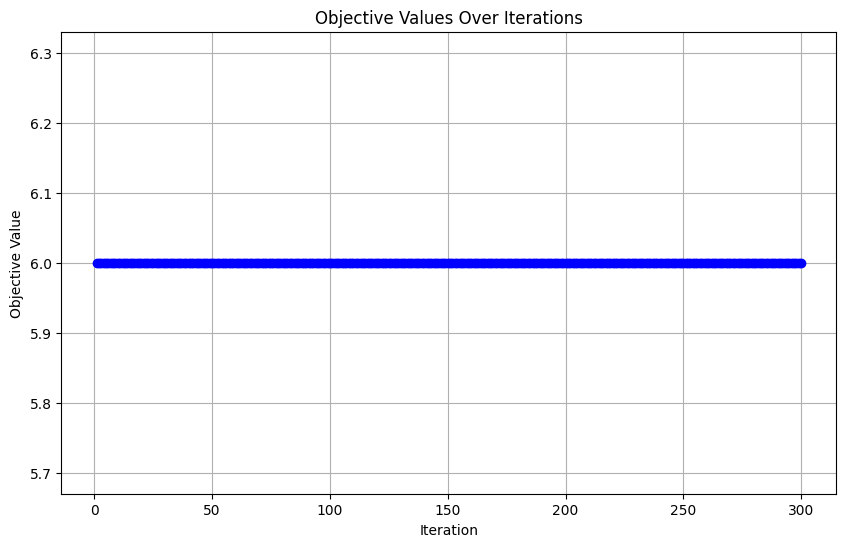

In [ ]:
# block to plot objective values over iterations

iterations = range(1, len(objectives) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, marker='o', linestyle='--', color='b')
plt.title('Objective Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()